In [ ]:
!pip install transformers
!pip install pytorch-crf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 80.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.7 MB/s eta 0:00:00


In [ ]:
import joblib
import torch
import torch.nn as nn
import transformers
from torchcrf import CRF
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn import model_selection

from tqdm import tqdm
from transformers import get_linear_schedule_with_warmup, AutoTokenizer, AutoModel, logging,AdamW




In [10]:
class config:
    MAX_LEN = 165
    TRAIN_BATCH_SIZE = 32
    VALID_BATCH_SIZE = 8
    BASE_MODEL_PATH = "vinai/phobert-base-v2"
    # MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/ner vietnam"
    TRAINING_FILE = "/content/drive/MyDrive/Colab Notebooks/vietnam ner/tonghop.csv"
    TESTING_FILE = "/content/drive/MyDrive/Colab Notebooks/vietnam ner/test_2016_final.csv"
    TOKENIZER = transformers.AutoTokenizer.from_pretrained(BASE_MODEL_PATH, do_lower_case=True)



Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
train_data = pd.read_csv(config.TRAINING_FILE,encoding='utf-16')
train_data.head()

Sentences     Word POS1 TAG
0          1  Tham_dự    V   O
1          1       lễ    N   O
2          1  công_bố    V   O
3          1       có    V   O
4          1      ông    N   O

In [12]:
test_data = pd.read_csv(config.TESTING_FILE, encoding='utf-16')
test_data.head()

Sentences     Word POS1    TAG
0          0      Chị   Nc      O
1          0     Minh   Np  B-PER
2          0       ôm    V      O
3          0      đứa   Nc      O
4          0  con_gái    N      O

In [ ]:
count = 0
count_list = []
previous_sentence = None

for sentence in test_data['Sentences']:
    if sentence != previous_sentence:
        count_list.append(count)
        count = 1
        previous_sentence = sentence
    else:
        count += 1


count_list.append(count)


print(max(count_list))

value =5
indices = [index for index, element in enumerate(count_list) if element == value]
print("Indices:", indices)

148
Indices: [153, 358, 361, 426, 434, 460, 471, 474, 485, 637, 646, 658, 989, 1129, 1141, 1218, 1236, 1434, 1614, 1625, 1628, 1785, 1864, 1904, 1923, 1949, 2016, 2118, 2180, 2277, 2322, 2478, 2494, 2537, 2543]


In [13]:
unique_values = train_data['TAG'].unique()
print(unique_values)


['O' 'B-PER' 'B-ORG' 'I-ORG' 'B-LOC' 'I-LOC' 'B-MISC' 'I-MISC']


In [14]:
class EntityDataset:
    def __init__(self, texts, pos, tags):
        self.texts = texts
        self.pos = pos
        self.tags = tags
    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = self.texts[item]
        pos = self.pos[item]
        tags = self.tags[item]

        ids = []
        target_pos = []
        target_tag =[]
        mask=[]
        token_type_ids=[]


        inputs = config.TOKENIZER.encode(
                text,
                add_special_tokens=False
            )
        input_len = len(inputs)
        padding_len =config.MAX_LEN - input_len
        ids.extend(inputs + [0]*padding_len )
        target_pos.extend(pos+ [2]*padding_len)
        target_tag.extend(tags + [8]*padding_len)

        mask.extend([1] * input_len + [0]*padding_len)
        token_type_ids.extend([0]*config.MAX_LEN)

        return {
            "ids": torch.tensor(ids, dtype=torch.long),
            "mask": torch.tensor(mask, dtype=torch.long),
            "token_type_ids": torch.tensor(token_type_ids, dtype=torch.long),
            "target_pos": torch.tensor(target_pos, dtype=torch.long),
            "target_tag": torch.tensor(target_tag, dtype=torch.long),
        }

In [15]:
def process_data(data_path):
    df = pd.read_csv(data_path,encoding='utf-16')

    df.dropna(inplace=True)

    enc_tag = preprocessing.LabelEncoder()
    enc_pos = preprocessing.LabelEncoder()
    df.loc[:, "TAG"] = enc_tag.fit_transform(df["TAG"])
    df.loc[:, "POS1"] = enc_pos.fit_transform(df["POS1"])

    sentences = df.groupby("Sentences")["Word"].apply(list).values
    tag = df.groupby("Sentences")["TAG"].apply(list).values
    pos= df.groupby("Sentences")["POS1"].apply(list).values
    df.loc[:, "OriginalLabel"] = enc_tag.inverse_transform(df["TAG"])
    df.loc[:, "OriginalPOS"] = enc_pos.inverse_transform(df["POS1"])


    label_mapping = df[["TAG", "OriginalLabel"]].drop_duplicates().sort_values("TAG")
    pos_mapping = df[["POS1", "OriginalPOS"]].drop_duplicates().sort_values("POS1")

    print("Label Mapping:")
    for _, row in label_mapping.iterrows():
        print(f"{row['TAG']}: {row['OriginalLabel']}")
    print("POS Mapping:")
    for _, row in pos_mapping.iterrows():

        print(f"{row['POS1']}: {row['OriginalPOS']}")


    return sentences, tag, enc_tag,pos,enc_pos

In [16]:
train_sentences, train_tag, enc_tag_train,pos_tag, enc_pos = process_data(config.TRAINING_FILE)

Label Mapping:
0: B-LOC
1: B-MISC
2: B-ORG
3: B-PER
4: I-LOC
5: I-MISC
6: I-ORG
7: O
POS Mapping:
0: A
1: C
2: CH
3: E
4: I
5: L
6: M
7: Mx
8: N
9: Nb
10: Nc
11: Np
12: Npy
13: Nu
14: Ny
15: O
16: P
17: R
18: T
19: V
20: X
21: Z


<ipython-input-15-9733d328cf64>:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "TAG"] = enc_tag.fit_transform(df["TAG"])
<ipython-input-15-9733d328cf64>:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "POS1"] = enc_pos.fit_transform(df["POS1"])


In [ ]:
meta_data = {
    "enc_pos": enc_pos,
    "enc_tag": enc_tag_train
}

joblib.dump(meta_data, "/content/drive/MyDrive/Colab Notebooks/vietnam ner/encoded.bin")

['/content/drive/MyDrive/Colab Notebooks/ner vietnam/encoded.bin']

In [ ]:
train_sentences

array([list(['Đó', 'là', 'con', 'đường', 'biển', 'ngắn', 'nhất', 'để', 'đi', 'từ', 'Ấn Độ Dương', 'sang', 'Thái Bình Dương', ',', 'chiếm', 'đến', 'lượng', 'hàng hoá', 'lưu thông', 'đường biển', 'của', 'thế giới', ',', 'đó', 'là', 'hải trình', 'lớn', 'nhất', 'từ', 'tây', 'sang', 'đông', 'với', '50.000', 'lượt', 'tàu bè', 'qua lại', 'mỗi', 'năm', '...']),
       list(['Một', 'chuyến', 'hải trình', 'xuyên', 'ba', 'nước', 'Malaysia', ',', 'Singapore', ',', 'Indonesia', 'vừa', 'được', 'phóng viên', 'Tuổi Trẻ', 'thực hiện', ',', 'để', 'cảm nhận', 'điều', 'mà', 'các', 'thuỷ thủ', 'tàu', 'viễn dương', 'đã', 'cảm nhận', 'mỗi', 'khi', 'nghe', 'nhắc', 'tới', ':', 'hải tặc', 'eo biển', 'Malacca', '!', '...']),
       list(['Từ', 'bức', 'điện', 'của', 'IMB', '...']), ...,
       list(['Cậu', 'bé', 'sôi nổi', 'nhiệt tình', 'ấy', 'không', 'hiểu', 'có', 'chịu', 'nổi', 'những', 'đòn', 'tra tấn', 'của', 'quân thù', 'hay', 'không', '.']),
       list(['Thương', 'Đường', 'vô tận', '.']),
       list(['Lá'

In [17]:
test_sentences, test_tag, enc_tag_test,pos_tag_test, enc_pos_test = process_data(config.TESTING_FILE)

<ipython-input-15-9733d328cf64>:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "TAG"] = enc_tag.fit_transform(df["TAG"])
<ipython-input-15-9733d328cf64>:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "POS1"] = enc_pos.fit_transform(df["POS1"])


Label Mapping:
0: B-LOC
1: B-MISC
2: B-ORG
3: B-PER
4: I-LOC
5: I-MISC
6: I-ORG
7: I-PER
8: O
POS Mapping:
0: A
1: C
2: CH
3: E
4: FW
5: I
6: L
7: M
8: N
9: Nc
10: Np
11: Nu
12: Ny
13: P
14: R
15: T
16: V
17: Vy
18: X
19: Z


In [ ]:
train_dataset = EntityDataset(texts=train_sentences, pos=pos_tag, tags=train_tag)

In [ ]:
train_dataset[0]

{'ids': tensor([  669,     8,    73,   109,   262,  1131,    67,    24,    57,    39,
         10148,   295,  2832,     4,   724,    30,   525,  1075,  2227, 12033,
             7,   198,     4,    37,     8, 31425,   103,    67,    39,  2615,
           295,   553,    15,  3976,  1030, 30254,  4457,   205,    29,   135,
           242,   550, 31425,  2121,   346,    58,  1396,     4,  1462,     4,
          1550,   164,    11,  1259, 12064,   112,     4,    24,  2601,   184,
            64,     9,  5840,   356,     3,    14,  2601,   205,    26,   523,
          1630,    75,    27, 29182, 10820, 31357,   381,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,  

In [ ]:
test_dataset = EntityDataset(texts=test_sentences, pos=pos_tag_test, tags=test_tag)

In [ ]:
for item in train_dataset:
    id = item['ids'].tolist()
    attention_mask = item['mask'].tolist()
    token_type_id = item['token_type_ids'].tolist()
    targets = item['target_tag'].tolist()
    pos = item['target_pos'].tolist()


    print("input id:", id)
    print("attention mask:", attention_mask)
    print("token type id:", token_type_id)
    print("pos:", pos)
    print("targets:", targets)



Output hidden; open in https://colab.research.google.com to view.

In [ ]:
for item in train_dataset:
    id = item['ids'].tolist()
    attention_mask = item['mask'].tolist()
    token_type_id = item['token_type_ids'].tolist()
    # targets = item['target_tag'].tolist()
    # pos = item['target_pos'].tolist()


    print("input id:", id)
    print("attention mask:", attention_mask)
    print("token type id:", token_type_id)
    # print("pos:", pos)
    # print("targets:", targets)



input id: [0, 669, 8, 73, 109, 262, 1131, 67, 24, 57, 39, 8978, 6267, 1962, 295, 1709, 1832, 1962, 4, 724, 30, 525, 119, 1738, 3230, 2178, 109, 262, 7, 570, 681, 4, 37, 8, 10317, 1893, 103, 67, 39, 2615, 295, 553, 15, 3976, 1030, 356, 6423, 89, 44, 205, 29, 135, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
attention mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

KeyboardInterrupt: ignored

In [ ]:
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.TRAIN_BATCH_SIZE, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=config.VALID_BATCH_SIZE, num_workers=1)

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
def train_fn(data_loader, model, optimizer,optimizer1, device, scheduler):
    model.train()
    pos_losses = []
    ner_losses = []

    predicted=[]
    real=[]
    predicted_pos=[]
    real_pos=[]



    for data in tqdm(data_loader, total=len(data_loader)):
        for k, v in data.items():
            data[k] = v.to(device)
        optimizer.zero_grad()
        optimizer1.zero_grad()
        output_tag, output_pos, loss_tag,loss = model(**data)
        # pro.append(p)




        loss.backward(retain_graph=True)
        loss_tag.backward(retain_graph=True)

        for sublist_a, sublist_b in zip(output_tag, data["target_tag"]):
          n = len(sublist_a)
          first_n_values = sublist_b[:n]

          real.append(first_n_values)
          predicted.append(sublist_a)

        for sublist_a, sublist_b in zip(output_pos, data["target_pos"]):
          n = len(sublist_a)
          first_n_values = sublist_b[:n]

          real_pos.append(first_n_values)
          predicted_pos.append(sublist_a)


        optimizer.step()
        optimizer1.step()
        scheduler.step()

        pos_losses.append(loss.item())
        ner_losses.append(loss_tag.item())

    avg_pos_loss = sum(pos_losses) / len(pos_losses)
    avg_ner_loss = sum(ner_losses) / len(ner_losses)

    y_true_tag = torch.tensor([label for sublist in real for label in sublist]).cpu()
    del real
    y_pred_tag = torch.tensor([label for sublist in predicted for label in sublist]).cpu()
    del predicted
    f1_tag = f1_score(y_true_tag, y_pred_tag, average='micro')

    y_true_pos = torch.tensor([label for sublist in real_pos for label in sublist]).cpu()
    del real_pos
    y_pred_pos = torch.tensor([label for sublist in predicted_pos for label in sublist]).cpu()
    del predicted_pos
    f1_pos = f1_score(y_true_pos, y_pred_pos, average='micro')


    return avg_pos_loss, avg_ner_loss,f1_pos,f1_tag

def eval_fn(data_loader, model, device):
    model.eval()
    pos_losses = []
    ner_losses = []

    predicted=[]
    real=[]
    predicted_pos=[]
    real_pos=[]



    with torch.no_grad():
      for data in tqdm(data_loader, total=len(data_loader)):
          for k, v in data.items():
              data[k] = v.to(device)

          output_tag, output_pos, loss_tag,loss = model(**data)

          pos_losses.append(loss.item())
          ner_losses.append(loss_tag.item())
          for sublist_a, sublist_b in zip(output_tag, data["target_tag"]):
            n = len(sublist_a)
            first_n_values = sublist_b[:n]

            real.append(first_n_values)
            predicted.append(sublist_a)

          for sublist_a, sublist_b in zip(output_pos, data["target_pos"]):
            n = len(sublist_a)
            first_n_values = sublist_b[:n]

            real_pos.append(first_n_values)
            predicted_pos.append(sublist_a)

      avg_pos_loss = sum(pos_losses) / len(pos_losses)
      avg_ner_loss = sum(ner_losses) / len(ner_losses)

      y_true_tag = torch.tensor([label for sublist in real for label in sublist]).cpu()
      del real
      y_pred_tag = torch.tensor([label for sublist in predicted for label in sublist]).cpu()
      del predicted
      f1_tag = f1_score(y_true_tag, y_pred_tag, average='micro')

      y_true_pos = torch.tensor([label for sublist in real_pos for label in sublist]).cpu()
      del real_pos
      y_pred_pos = torch.tensor([label for sublist in predicted_pos for label in sublist]).cpu()
      del predicted_pos
      f1_pos = f1_score(y_true_pos, y_pred_pos, average='micro')


    return avg_pos_loss, avg_ner_loss,f1_pos,f1_tag


In [ ]:
import torch.nn.functional as F
log_soft = F.log_softmax

In [ ]:
class EntityModel(nn.Module):
    def __init__(self, num_tag, num_pos):
        super(EntityModel, self).__init__()
        self.num_tag = num_tag
        self.num_pos = num_pos
        self.phobert = transformers.AutoModel.from_pretrained(config.BASE_MODEL_PATH,return_dict=False)
        # for param in self.phobert.parameters():
        #     param.requires_grad = False
        self.bert_drop_1 = nn.Dropout(0.3)
        self.bert_drop_2 = nn.Dropout(0.3)
        self.out_tag = nn.Linear(768, self.num_tag)
        self.out_pos = nn.Linear(768, self.num_pos)
        self.crf = CRF(num_tag, batch_first = True)
        self.crf_pos = CRF(num_pos, batch_first = True)
    def forward(
        self,
        ids,
        mask,
        token_type_ids,
        target_pos,
        target_tag
    ):
        o1, _ = self.phobert(
            ids,
            attention_mask=mask,
            token_type_ids=token_type_ids
        )

        bo_tag = self.bert_drop_1(o1)
        bo_pos = self.bert_drop_2(o1)

        tag = self.out_tag(bo_tag)
        pos = self.out_pos(bo_pos)



        if target_tag is not None:
            loss_tag = -self.crf(log_soft(tag, 2), target_tag, mask=mask.type(torch.uint8), reduction='mean')
            prediction = self.crf.decode(tag, mask=mask.type(torch.uint8))


        else:
            prediction = self.crf.decode(tag, mask=mask.type(torch.uint8))
            # return prediction

        if target_pos is not None:
            loss_pos = -self.crf_pos(log_soft(pos, 2), target_pos, mask=mask.type(torch.uint8), reduction='mean')
            pos_prediction = self.crf_pos.decode(pos, mask=mask.type(torch.uint8))


        else:
            pos_prediction = self.crf_pos.decode(pos, mask=mask.type(torch.uint8))


        return prediction, pos_prediction,loss_tag,loss_pos

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda')

In [ ]:
num_tag = len(list(enc_tag_train.classes_))
num_pos = len(list(enc_pos.classes_))

In [ ]:
num_tag

9

In [ ]:
num_pos

20

In [ ]:
model = EntityModel(num_tag=9, num_pos=20)
model.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EntityModel(
  (phobert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNo

In [ ]:
param_optimizer = list(model.named_parameters())
# no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
# optimizer_parameters = [
#     {
#         "params": [
#             p for n, p in param_optimizer if not any(
#                 nd in n for nd in no_decay
#             )
#         ],
#         "weight_decay": 0.01,
#     },
#     {
#         "params": [
#             p for n, p in param_optimizer if any(
#                 nd in n for nd in no_decay
#             )
#         ],
#         "weight_decay": 0.01,
#     },
# ]


In [ ]:
param_optimizer

[('phobert.embeddings.word_embeddings.weight',
  Parameter containing:
  tensor([[ 0.0367, -0.0131, -0.0562,  ...,  0.0061,  0.0037, -0.0051],
          [ 0.0359,  0.0122, -0.0007,  ...,  0.0014, -0.0053,  0.0222],
          [ 0.0252,  0.0068, -0.0004,  ..., -0.0183,  0.0312,  0.0361],
          ...,
          [ 0.0403, -0.0513, -0.0025,  ..., -0.0355, -0.0694,  0.0204],
          [ 0.0535,  0.0157, -0.0067,  ...,  0.0222, -0.0061,  0.0074],
          [ 0.0360,  0.0015, -0.0145,  ...,  0.0104, -0.0065,  0.0368]],
         device='cuda:0')),
 ('phobert.embeddings.position_embeddings.weight',
  Parameter containing:
  tensor([[ 0.0075, -0.0013, -0.0034,  ..., -0.0011,  0.0038,  0.0054],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [-0.0062,  0.0027, -0.0442,  ...,  0.0060, -0.0080,  0.0762],
          ...,
          [ 0.0037, -0.0170, -0.0121,  ..., -0.0130,  0.0182,  0.0365],
          [-0.0017, -0.0339, -0.0187,  ..., -0.0186, -0.0128,  0.0281],
   

In [ ]:
optimizer_parameters

[{'params': [Parameter containing:
   tensor([[ 0.0367, -0.0131, -0.0562,  ...,  0.0061,  0.0037, -0.0051],
           [ 0.0359,  0.0122, -0.0007,  ...,  0.0014, -0.0053,  0.0222],
           [ 0.0252,  0.0068, -0.0004,  ..., -0.0183,  0.0312,  0.0361],
           ...,
           [ 0.0403, -0.0513, -0.0025,  ..., -0.0355, -0.0694,  0.0204],
           [ 0.0535,  0.0157, -0.0067,  ...,  0.0222, -0.0061,  0.0074],
           [ 0.0360,  0.0015, -0.0145,  ...,  0.0104, -0.0065,  0.0368]],
          device='cuda:0'),
   Parameter containing:
   tensor([[ 0.0075, -0.0013, -0.0034,  ..., -0.0011,  0.0038,  0.0054],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [-0.0062,  0.0027, -0.0442,  ...,  0.0060, -0.0080,  0.0762],
           ...,
           [ 0.0037, -0.0170, -0.0121,  ..., -0.0130,  0.0182,  0.0365],
           [-0.0017, -0.0339, -0.0187,  ..., -0.0186, -0.0128,  0.0281],
           [-0.0218,  0.0849, -0.0456,  ..., -0.1043,  0.1484,  0.0963]],
  

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

35159

In [ ]:
del model

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
# no_decay = ['bias', 'gamma', 'beta','LayerNorm.weight','LayerNorm.bias']
optimizer_parameters = [
    {
        "params": [
            p for n, p in param_optimizer if not any(
                nd in n for nd in no_decay
            )
        ],
        "weight_decay": 0.01,
    },
    {
        "params": [
            p for n, p in param_optimizer if any(
                nd in n for nd in no_decay
            )
        ],
        "weight_decay": 0.01,
    },
]

In [ ]:
optimizer_parameters

[{'params': [Parameter containing:
   tensor([[ 0.0367, -0.0131, -0.0562,  ...,  0.0061,  0.0037, -0.0051],
           [ 0.0359,  0.0122, -0.0007,  ...,  0.0014, -0.0053,  0.0222],
           [ 0.0252,  0.0068, -0.0004,  ..., -0.0183,  0.0312,  0.0361],
           ...,
           [ 0.0403, -0.0513, -0.0025,  ..., -0.0355, -0.0694,  0.0204],
           [ 0.0535,  0.0157, -0.0067,  ...,  0.0222, -0.0061,  0.0074],
           [ 0.0360,  0.0015, -0.0145,  ...,  0.0104, -0.0065,  0.0368]],
          device='cuda:0'),
   Parameter containing:
   tensor([[ 0.0075, -0.0013, -0.0034,  ..., -0.0011,  0.0038,  0.0054],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [-0.0062,  0.0027, -0.0442,  ...,  0.0060, -0.0080,  0.0762],
           ...,
           [ 0.0037, -0.0170, -0.0121,  ..., -0.0130,  0.0182,  0.0365],
           [-0.0017, -0.0339, -0.0187,  ..., -0.0186, -0.0128,  0.0281],
           [-0.0218,  0.0849, -0.0456,  ..., -0.1043,  0.1484,  0.0963]],
  

In [ ]:
param_optimizer = list(model.named_parameters())
# no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
# no_decay = ['bias', 'gamma', 'beta','LayerNorm.weight','LayerNorm.bias']
no_decay = ['bias', 'gamma', 'beta']
optimizer_parameters = [
    {
        "params": [
            p for n, p in param_optimizer if not any(
                nd in n for nd in no_decay
            )
        ],
        "weight_decay": 0.01,
    },
    {
        "params": [
            p for n, p in param_optimizer if any(
                nd in n for nd in no_decay
            )
        ],
        "weight_decay": 0.01,
    },
]

num_train_steps = int(
    len(train_sentences) / config.TRAIN_BATCH_SIZE * 10
)
optimizer = AdamW(optimizer_parameters, lr=3e-5)
optimizer1 = AdamW(optimizer_parameters, lr=3e-5)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=num_train_steps
)

best_loss = np.inf
# best_acc = 0.0
for epoch in range(15):
    train_pos_losses, train_ner_losses,f1_pos_train,f1_tag_train = train_fn(
        train_data_loader,
        model,
        optimizer,
        optimizer1,
        device,
        scheduler
    )

    test_pos_losses, test_ner_losses,f1_pos_test,f1_tag_test = eval_fn(
        test_data_loader,
        model,
        device
    )

    print(f"Train POS Loss = {train_pos_losses:.4f}")
    print(f"Train NER Loss = {train_ner_losses:.4f}")
    print(f"Valid POS Loss = {test_pos_losses:.4f}")
    print(f"Valid NER Loss = {test_ner_losses:.4f}")

    print(f"Train POS F1 = {f1_pos_train:.4f}")
    print(f"Train NER f1 = {f1_tag_train:.4f}")
    print(f"Valid POS f1 = {f1_pos_test:.4f}")
    print(f"Valid NER f1 = {f1_tag_test:.4f}")


    test=test_pos_losses + test_ner_losses
    if test < best_loss:
        torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/test_model/best_model_crf2.pth')
        print("Save model.")
        best_loss = test

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/425 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchcrf/__init__.py:249: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at ../aten/src/ATen/native/TensorCompare.cpp:493.)
  score = torch.where(mask[i].unsqueeze(1), next_score, score)
100%|██████████| 322/322 [01:04<00:00,  5.00it/s]


Train POS Loss = 20.2019
Train NER Loss = 5.8664
Valid POS Loss = 9.6080
Valid NER Loss = 2.6689
Train POS F1 = 0.8008
Train NER f1 = 0.9611
Valid POS f1 = 0.9048
Valid NER f1 = 0.9807
Save model.


  0%|          | 0/425 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 322/322 [01:06<00:00,  4.86it/s]


Train POS Loss = 7.4854
Train NER Loss = 1.7889
Valid POS Loss = 7.8426
Valid NER Loss = 1.6411
Train POS F1 = 0.9181
Train NER f1 = 0.9858
Valid POS f1 = 0.9113
Valid NER f1 = 0.9861
Save model.


  0%|          | 0/425 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 322/322 [01:05<00:00,  4.92it/s]


Train POS Loss = 5.8180
Train NER Loss = 1.0793
Valid POS Loss = 6.8657
Valid NER Loss = 1.1522
Train POS F1 = 0.9301
Train NER f1 = 0.9905
Valid POS f1 = 0.9208
Valid NER f1 = 0.9891
Save model.


  0%|          | 0/425 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 322/322 [01:05<00:00,  4.90it/s]


Train POS Loss = 4.7615
Train NER Loss = 0.7480
Valid POS Loss = 6.5164
Valid NER Loss = 0.9936
Train POS F1 = 0.9415
Train NER f1 = 0.9931
Valid POS f1 = 0.9245
Valid NER f1 = 0.9907
Save model.


  0%|          | 0/425 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 322/322 [01:04<00:00,  4.97it/s]


Train POS Loss = 4.0883
Train NER Loss = 0.5737
Valid POS Loss = 6.5404
Valid NER Loss = 1.0313
Train POS F1 = 0.9487
Train NER f1 = 0.9944
Valid POS f1 = 0.9268
Valid NER f1 = 0.9897


  0%|          | 0/425 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 322/322 [01:04<00:00,  5.00it/s]


Train POS Loss = 3.9430
Train NER Loss = 0.6655
Valid POS Loss = 6.4920
Valid NER Loss = 1.0742
Train POS F1 = 0.9501
Train NER f1 = 0.9932
Valid POS f1 = 0.9269
Valid NER f1 = 0.9891


  0%|          | 0/425 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 322/322 [01:05<00:00,  4.91it/s]


Train POS Loss = 3.4155
Train NER Loss = 0.4064
Valid POS Loss = 6.4776
Valid NER Loss = 1.0670
Train POS F1 = 0.9562
Train NER f1 = 0.9959
Valid POS f1 = 0.9283
Valid NER f1 = 0.9892


  0%|          | 0/425 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
 11%|█         | 35/322 [00:07<01:03,  4.51it/s]

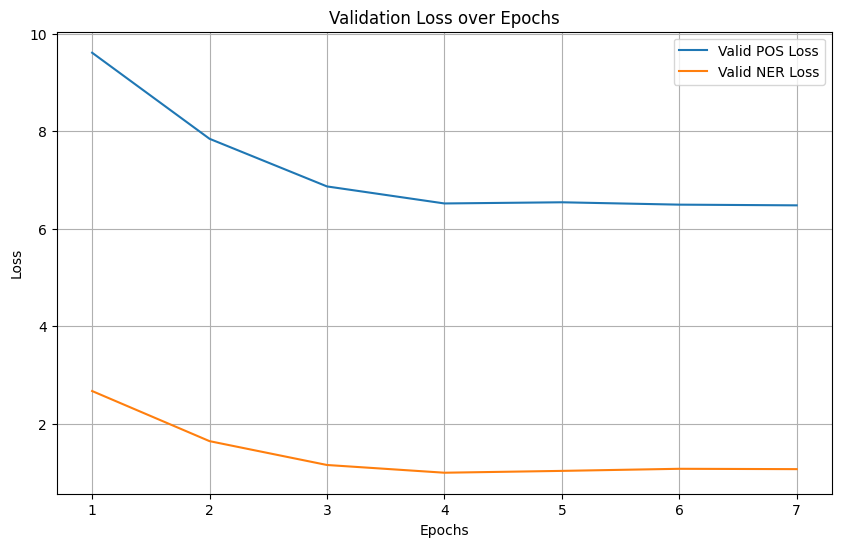

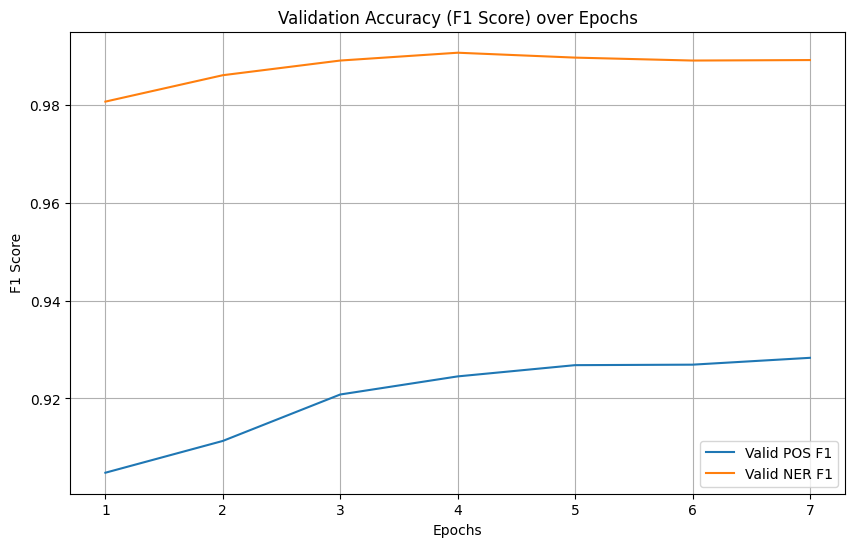

In [ ]:
import matplotlib.pyplot as plt


epochs = range(1, 8)


train_pos_loss = [20.2019, 7.4854, 5.8180, 4.7615, 4.0883, 3.9430, 3.4155]
train_ner_loss = [5.8664, 1.7889, 1.0793, 0.7480, 0.5737, 0.6655, 0.4064]
valid_pos_loss = [9.6080, 7.8426, 6.8657, 6.5164, 6.5404, 6.4920, 6.4776]
valid_ner_loss = [2.6689, 1.6411, 1.1522, 0.9936, 1.0313, 1.0742, 1.0670]


train_pos_f1 = [0.8008, 0.9181, 0.9301, 0.9415, 0.9487, 0.9501, 0.9562]
train_ner_f1 = [0.9611, 0.9858, 0.9905, 0.9931, 0.9944, 0.9932, 0.9959]
valid_pos_f1 = [0.9048, 0.9113, 0.9208, 0.9245, 0.9268, 0.9269, 0.9283]
valid_ner_f1 = [0.9807, 0.9861, 0.9891, 0.9907, 0.9897, 0.9891, 0.9892]


plt.figure(figsize=(10, 6))
plt.plot(epochs, valid_pos_loss, label='Valid POS Loss')
plt.plot(epochs, valid_ner_loss, label='Valid NER Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot Valid Accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, valid_pos_f1, label='Valid POS F1')
plt.plot(epochs, valid_ner_f1, label='Valid NER F1')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Validation Accuracy (F1 Score) over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/test_model/best_model_crf2.pth')

In [ ]:
meta_data = joblib.load("/content/drive/MyDrive/Colab Notebooks/ner vietnam/encoded.bin")
enc_pos = meta_data["enc_pos"]
enc_tag = meta_data["enc_tag"]

num_pos = len(list(enc_pos.classes_))
num_tag = len(list(enc_tag.classes_))
model = EntityModel(num_tag=9, num_pos=20)
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/ner vietnam/best_model.pth', map_location=torch.device('cpu')))
model.to(device)

Some weights of the model checkpoint at vinai/phobert-base-v2 were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EntityModel(
  (phobert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNo